This is a technical description of banded ridge regression (see [Nunez-Elizalde, et al., 2019](https://doi.org/10.1016/j.neuroimage.2019.04.012))

In [1]:
%matplotlib inline

In [2]:
import matplotlib
matplotlib.rcParams['figure.figsize'] = [7., 7.]
matplotlib.rcParams['font.size'] = 15

In [3]:
import os
import time

import numpy as np
np.random.seed(1337)
np.set_printoptions(precision=4, suppress=True)

from scipy.stats import zscore
from matplotlib import pyplot as plt

from tikreg import models, utils as tikutils
from tikreg import spatial_priors, temporal_priors

# Banded ridge regression with two feature spaces

When estimating a joint encoding model that consists of two feature spaces, banded ridge regression can be used to to fit the model and assign each feature space a different regularization parameter. 

$$Y = X_1 \beta_1 + X_2 \beta_2 + \epsilon$$

$$
\begin{align*}
\beta_1 \sim \mathcal{N}\left(0, \lambda_1^{-2} I_p\right)\\
\beta_2 \sim \mathcal{N}\left(0, \lambda_2^{-2} I_q\right)\\
\end{align*}
$$

However, this requires cross-validating two regularization parameters ($\lambda_1$ and $\lambda_2$), which can be computationally expensive.

### Cartesian grid search 

Suppose we have two feature spaces $X_1$ and $X_2$ each with a corresponding regularization parameter: $\lambda_1$ and $\lambda_2$. In order to find the optimal regularization parameter via cross-validation, we'll have to test all combinations of $\lambda_1$ and $\lambda_2$. For 10 hyperparameter values, a grid search requires a total of $10^2$  evaluations. In general, for $N$ hyperparameter values and $M$ models, a grid search requires the evaluation fo $N^M$ points. This can be computationally expensive.

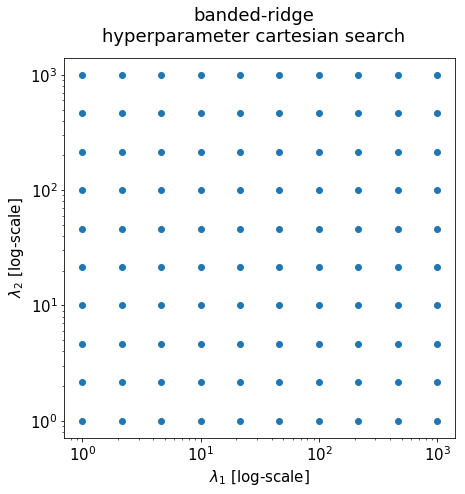

In [4]:
import itertools
lambda_one_candidates = np.logspace(0,3,10)
lambda_two_candidates = np.logspace(0,3,10)

all_pairs = np.asarray(list(itertools.product(lambda_one_candidates, lambda_two_candidates)))

fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.loglog(all_pairs[:,0], all_pairs[:,1], 'o')
ax.set_xlabel(r'$\lambda_1$ [log-scale]')
ax.set_ylabel(r'$\lambda_2$ [log-scale]')
__ = fig.suptitle('banded-ridge\nhyperparameter cartesian search')

### Polar grid search

Luckily, we can gain some computational efficiency by sampling hyperparameters using a polar grid search instead of a cartesian search. 

This computational trick is nothing more than a change in coordinate systems. The hyperparameters $\lambda_1$ and $\lambda_2$ can be mapped to and from cartesian and polar coordinates. So we can always convert from one to the other without loss of generaility.



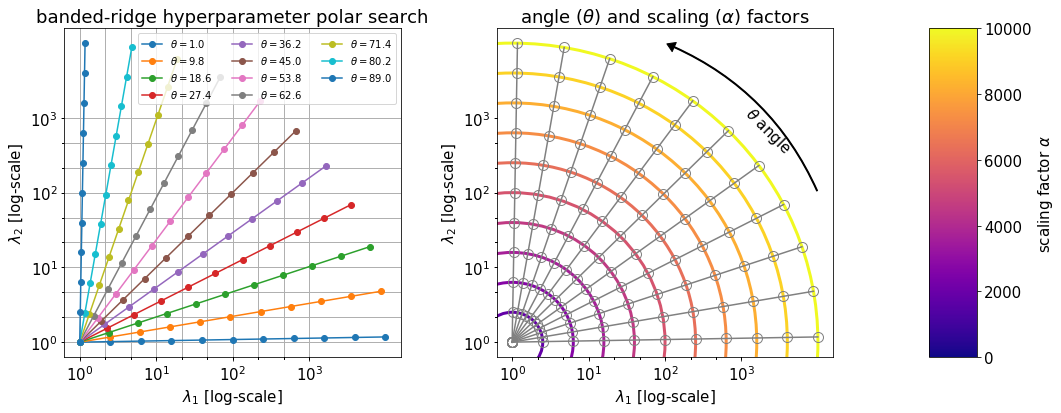

In [5]:
import matplotlib.patches as patches

fig = plt.figure(figsize=(15,6))

ax = plt.subplot2grid((1, 7), (0, 0), colspan=3, fig=fig)
ax2 = plt.subplot2grid((1, 7), (0, 3), colspan=3, fig=fig)
ax3 = plt.subplot2grid((1, 7), (0, 6), fig=fig)

# Polar sampling
radii = np.logspace(0,4,11)
angles = np.deg2rad(np.linspace(1, 89,11))
for iangle, angle in enumerate(angles):
    ypos = np.sin(angle)*np.log10(radii) # lambda2 values [log10-scale]
    xpos = np.cos(angle)*np.log10(radii) # lambda1 values [log10-scale]

    # plot
    ax.plot(xpos, ypos, 'o-', label=r'$\theta=%0.1f$'%np.rad2deg(angle))
    ax2.plot(xpos, ypos, color='grey', 
             marker='o', markerfacecolor='none', markersize=10, alpha=1.0)

# scaling radii
for cdx, radius in enumerate(radii):
    radius_color = plt.cm.plasma((float(cdx+1)/len(radii)))
    circle = plt.Circle((0,0), np.log10(radius), color=radius_color, fill=False, lw=3.)
    ax2.add_artist(circle)

# angle arrow
style="Simple,tail_width=1.0,head_width=10,head_length=8"
kw = dict(arrowstyle=style, color="k")
arrow = patches.FancyArrowPatch((4,2),(2,4), connectionstyle="arc3,rad=0.2", **kw)
ax2.add_patch(arrow)
ax2.text(3,3, r'$\theta$ angle', rotation=-45)

# Add colorbar for the radii
cbar = matplotlib.colorbar.ColorbarBase(ax3, 
                                        cmap=plt.cm.plasma, 
                                        norm=matplotlib.colors.Normalize(0,10**4),
                                        orientation='vertical')
cbar.set_label(r'scaling factor $\alpha$')

# labels
for axx in [ax, ax2]:
    # Set cartesian sampling as grid
    axx.set_yticks(np.log10(all_pairs[:,0]), minor=True)
    axx.set_xticks(np.log10(all_pairs[:,0]), minor=True)

    axx.set_xlabel(r'$\lambda_1$ [log-scale]')
    axx.set_ylabel(r'$\lambda_2$ [log-scale]')
    axx.set_xticks([0, 1, 2, 3], minor=False)
    axx.set_yticks([0, 1, 2, 3], minor=False)
    __ = axx.set_xticklabels(['$10^0$', '$10^1$', '$10^2$', '$10^3$'], fontsize=15)
    __ = axx.set_yticklabels(['$10^0$', '$10^1$', '$10^2$', '$10^3$'], fontsize=15)
    
ax.grid(True, which='minor')
ax.legend(loc='best', ncol=3, fontsize=10)
__ = ax.set_title('banded-ridge hyperparameter polar search')
__ = ax2.set_title(r'angle ($\theta$) and scaling ($\alpha$) factors')
plt.tight_layout()

Each ray above corresponds to a set of hyperparameter combinations at a fixed ratio. 
$$r = \left(\frac{\lambda_2}{\lambda_1}\right)$$

The ratio between $\lambda_1$ and $\lambda_2$ defines an angle:
$$\theta = \text{tan}^{-1}\left(\frac{\lambda_2}{\lambda_1}\right)$$

And the angle defines a ratio:
$$\left(\frac{\lambda_2}{\lambda_1}\right) = \text{tan}(\theta)$$

For example, $\theta=45$ defines a set of solutions where the ratio between $\lambda_1$ and $\lambda_2$ is constant:

$$\frac{\lambda_2=1}{\lambda_1=1} = \frac{\lambda_2=10}{\lambda_1=10} = \frac{\lambda_2=100}{\lambda_1=100}$$

These solutions can be expressed as a ratio $r$ times a scaling controlled by $\alpha$:

$$\frac{\lambda_2 \alpha}{\lambda_1\alpha} = r \alpha$$

Thus, we can define the polar hyperparameter search in terms of ratios and scalings along the unit circle:

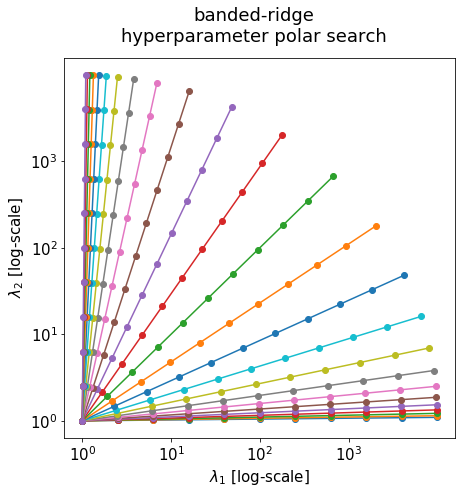

In [6]:
# Sampling in terms of ratios and scalings
alphas = np.logspace(0,4,11)
ratios = np.logspace(-2,2,25)

fig = plt.figure()
ax = fig.add_subplot(1,1,1)

for ratio in ratios:
    angle = np.arctan(ratio)
    ypos = np.sin(angle)*np.log10(alphas)
    xpos = np.cos(angle)*np.log10(alphas)
    ax.plot(xpos, ypos, 'o-')

ax.set_xticks([0, 1, 2, 3], minor=False)
ax.set_yticks([0, 1, 2, 3], minor=False)
__ = ax.set_xticklabels(['$10^0$', '$10^1$', '$10^2$', '$10^3$'], fontsize=15)
__ = ax.set_yticklabels(['$10^0$', '$10^1$', '$10^2$', '$10^3$'], fontsize=15)

# Labels
ax.set_xlabel(r'$\lambda_1$ [log-scale]')
ax.set_ylabel(r'$\lambda_2$ [log-scale]')
__ = fig.suptitle('banded-ridge\nhyperparameter polar search')

## Banded ridge with polar search: efficiency

Recall the Tikhohnov regression solution is

$$\hat{\beta}_{Tikhonov} = (X^\top X + C^\top C)^{-1} X^\top Y$$

For banded ridge regression, $C$ consist of a diagonal matrix where the first $p$ entries have a value of $\lambda_1$ and the last $q$ entries have a value of $\lambda_2$.

The solution to the banded ridge regression problem can be expressed as:


$$\hat{\beta}_{banded\_ridge} = 
\begin{bmatrix}
\hat{\beta}_1 \\ 
\hat{\beta}_2
\end{bmatrix} = 
\left(\begin{bmatrix}
X_1^\top X_1 & X_1^\top X_2 \\
X_2^\top X_1 & X_2^\top X_2 \\
\end{bmatrix}
+
\begin{bmatrix}
\lambda_1^2 I_p & 0 \\
0 & \lambda_2^2 I_q \\
\end{bmatrix} \right)^{-1}
\begin{bmatrix}
X_1^\top \\ X_2^\top
\end{bmatrix} Y
$$


In order to select the optimal regularization parameters for each feature space $\lambda^\ast_1$ and $\lambda^\ast_2$, we have to perform cross-validation and compute the Tikhonov solution for each candidate $\lambda_1$ and $\lambda_2$: $$\hat{\beta}_{banded\_ridge}^{\lambda^\text{'}_1, \lambda^\text{'}_2}$$

Thus, cross-validating for 100 hyperparameter combinations will take 100 times the amount of time it takes to compute the solution for one hyperparameter combination. This is a costly endeavour since each solution requires computing the inverse:

$$\left(X^\top X + C^\top C\right)^{-1}$$

However, we can achieve better computational performance using the standard transform. It turns out that using the standard transform corresponds to a polar sampling of the hyperparameters. This trick allows us to solve multiple solutions along each ray at the cost of one singular value decomposition (SVD) and many matrix multiplications. Because the computational cost of a matrix  multiplication is lower than the cost of the SVD or inverse, it is faster to perform a polar grid search than a cartesian grid search. 

## Banded ridge with polar search: math

In what follows, we show how to solve the banded ridge regression problem using the standard transform. We show the specific numerical and mathematical steps required to go from the standard form solution.

We first generate some random data.

In [7]:
nsamples = 1000
npfeatures = 100
nqfeatures = 200
nresponses = 100
X1 = np.random.randn(nsamples, npfeatures)
X2 = np.random.randn(nsamples, nqfeatures)
Ytrain = np.random.randn(nsamples, nresponses)

We next compute the banded ridge regression solution directly. 

$$\hat{\beta}_{banded\_ridge} = (X^\top X + C^\top C)^{-1} X^\top Y$$

where 
$$C = \begin{bmatrix}
\lambda_1 I_p & 0 \\
0 & \lambda_2 I_q \\
\end{bmatrix}
$$

In these examples, we set $\lambda_1 = 30$ and $\lambda_2 = 20$.

In [8]:
# Direct banded ridge solution
lambda_one = 30.0
lambda_two = 20.0

bands = np.asarray([lambda_one]*X1.shape[1] + [lambda_two]*X2.shape[1])
C = np.diag(bands)
Xjoint = np.hstack([X1, X2])

LH = np.linalg.inv(np.dot(Xjoint.T, Xjoint) + np.dot(C.T, C))
XTY = np.dot(Xjoint.T, Ytrain)
solution_direct_solution = np.dot(LH, XTY)

Using the standard transform, the banded ridge regression problem has a simple structure

$$A = X C^{-1} = \left[\frac{X_1}{\lambda_1} \frac{X_1}{\lambda_2}\right]$$

The standard form solution to the banded ridge regression problem can be expressed as

$$\hat{\beta}_{banded\_standard} = (A^\top A + I_{p+q})^{-1} A^\top Y$$

Finally, the solution to the banded ridge regression problem is

$$\hat{\beta}_{banded\_ridge} = C^{-1}\hat{\beta}_{banded\_standard}$$

In what follows, we validate this result numerically.

In [9]:
# Standard form solution
lambda_one = 30.0
lambda_two = 20.0
alpha = 1.0
Xjoint = np.hstack([X1/lambda_one, X2/lambda_two])

LH = np.linalg.inv(np.dot(Xjoint.T, Xjoint) + (alpha**2)*np.eye(Xjoint.shape[1]))
RH = np.dot(Xjoint.T, Ytrain)
bands = np.asarray([lambda_one]*X1.shape[1] + [lambda_two]*X2.shape[1])
Cinv = np.diag(bands**-1)
solution_banded_standard = np.dot(LH, RH)
solution_banded_stand2tik = np.dot(Cinv, solution_banded_standard)

print(np.corrcoef(solution_banded_stand2tik.ravel(), solution_direct_solution.ravel()))
print(np.allclose(solution_banded_stand2tik, solution_direct_solution))

[[1. 1.]
 [1. 1.]]
True


Thus far, we have been using the raw regularization parameters $\lambda_1$ and $\lambda_2$. However, note that the ratio of the regularization parameters is the same for both $\lambda_1=30, \lambda_2 = 20$ and $\lambda_1=3, \lambda_2 = 2$:

$$\frac{\lambda_2=20}{\lambda_1=30} = \frac{2}{3}\times 10$$

And in fact, the standard form solution to the banded ridge regression problem can be modified to accomodate this fact

$$A = \left[\frac{X_1}{\lambda_1 / 10} \frac{X_2}{\lambda_2/10}\right]$$

Note however that the factor of $10$ needs to be applied back to the solution in order to obtain an exact result:

$$\hat{\beta}_{banded\_standard} = 10\times (A^\top A + 10^2 I_{p+q})^{-1} A^\top Y$$

The scalar factor is $10$ in this example. In general, we refer to this scaling factor as $\alpha$.

In [10]:
# Scaling the standard form solution with alpha
lambda_one = 3.0
lambda_two = 2.0
alpha = 10.0

Xjoint = np.hstack([X1/lambda_one, X2/lambda_two])

LH = np.linalg.inv(np.dot(Xjoint.T, Xjoint) + (alpha**2.0)*np.eye(Xjoint.shape[1]))
RH = np.dot(Xjoint.T, Ytrain)
solution_standard_scaled = np.dot(LH, RH)*alpha

# Check the standard form solution
print(np.corrcoef(solution_standard_scaled.ravel(), solution_banded_standard.ravel()))
print(np.allclose(solution_standard_scaled, solution_banded_standard))

# Check the tikhonov solution
solution_bandstd2tik = np.dot(Cinv, solution_standard_scaled)
print(np.corrcoef(solution_bandstd2tik.ravel(),  solution_direct_solution.ravel()))
print(np.allclose(solution_bandstd2tik, solution_direct_solution))

[[1. 1.]
 [1. 1.]]
True
[[1. 1.]
 [1. 1.]]
True


More generally, for any given ratio $r = \frac{\lambda_2}{\lambda_1}$, multiple regularization parameters can be obtained by a simple scaling with a constant $\alpha$:

$$\left(\frac{\lambda_2}{\lambda_1}\right)\alpha = r\alpha$$

In general, the standard transform for banded ridge can be expressed as
$$A = \left[\frac{X_1}{\lambda_1 / \alpha} \frac{X_2}{\lambda_2/\alpha}\right]$$

And the banded ridge solution becomes:
$$\hat{\beta}_{banded\_ridge} = \alpha C^{-1} (A^\top A + \alpha^2 I_{p+q})^{-1} A^\top Y$$

Expanding $\alpha C^{-1}$:

$$ \hat{\beta}_{banded\_ridge} = 
\begin{bmatrix} 
\frac{\alpha}{\lambda_1} I_p & 0 \\
0 & \frac{\alpha}{\lambda_2} I_q \\
\end{bmatrix}
(A^\top A + \alpha^2 I_{p+q})^{-1} A^\top Y $$

### Why would you ever want to do that?

It tuns out we can solve this problem very efficiently for multiple values of $\alpha$ using the fact that $\left(A^\top A + \alpha^2 I \right)$ is simultaneously diagonalizable. This property allows us to compute solutions for multiple $\alpha$ scalings using only one singular value decomposition (SVD).

To illustrate, recall the singular value decomposition of $A$:
$$U S V^\top = A $$

We substitute $A$ with its SVD decomposition in the inverse of the banded ridge solution:

$$\left(A^\top A + \alpha^2 I \right)^{-1} = \left(V S^2 V^\top + \alpha^2 I \right)^{- 1}$$

Because $V$ is an orthogonal matrix and $S$ and $\alpha^2 I$ are diagonal matrices, their sum is simultaneously diagonalizable and can be expressed as:

$$
\begin{align*}
\left(A^\top A + \alpha^2 I \right)^{-1} &= \left(V \left(S^2 + \alpha^2 I\right) V^\top \right)^{- 1}\\
\left(A^\top A + \alpha^2 I \right)^{-1} &= V \left(\frac{1}{S^2 + \alpha^2 I}\right) V^\top
\end{align*}
$$

And because
$$A^\top Y = V S U^\top Y$$

The expression for the solution can be further simplified:
$$\left(A^\top A + \alpha^2 I \right)^{-1} A^\top Y = V \left(\frac{S}{S^2 + \alpha^2 I}\right) U^\top Y$$

And so, for a given ratio $\frac{\lambda_2}{\lambda_1}$, the solution becomes:

$$\hat{\beta}^{\frac{\lambda_2}{\lambda_1}}_{banded\_standard} = V D U^\top Y$$

where

$$D \equiv \left(\frac{S}{S^2 + \alpha^2 I}\right)$$

Because $U^\top Y$ can be cached, computing the solutions for multiple $\alpha$ scalings requires only a matrix multiplication operation and we only have to compute the SVD once per ratio.

In [11]:
# Simultaneous diagonalizability trick: one alpha
lambda_one = 3.0
lambda_two = 2.0
alpha = 10.0

A = np.hstack([X1/lambda_one, X2/lambda_two])

start_time = time.time()
U, S, VT = np.linalg.svd(A, full_matrices=False)
V = VT.T
UTY = np.dot(U.T, Ytrain)
D = np.diag(S / (S**2 + alpha**2))

solution_svd_standard = np.linalg.multi_dot([V, D, UTY])*alpha
solution_svd_bandstd2tik = np.dot(Cinv, solution_svd_standard)
one_dur = time.time() - start_time
print('Duration: %0.04f'%one_dur)

# Check the standard form solution
print(np.corrcoef(solution_svd_standard.ravel(), solution_banded_standard.ravel()))
print(np.allclose(solution_svd_standard, solution_banded_standard))

# Check the tikhonov solution
print(np.corrcoef(solution_svd_bandstd2tik.ravel(),  solution_direct_solution.ravel()))
print(np.allclose(solution_svd_bandstd2tik, solution_direct_solution))

Duration: 0.0367
[[1. 1.]
 [1. 1.]]
True
[[1. 1.]
 [1. 1.]]
True


We now show that this formulation allows us to compute the solution for multiple values of $\alpha$


In [12]:
# Simultaneous diagonalizability trick: multiple alphas
lambda_one = 3.0
lambda_two = 2.0
alphas = np.logspace(0,4,10)

A = np.hstack([X1/lambda_one, X2/lambda_two])

start_time = time.time()
U, S, VT = np.linalg.svd(A, full_matrices=False)
V = VT.T
for alpha in alphas:
    UTY = np.dot(U.T, Ytrain)
    D = np.diag(S / (S**2 + alpha**2))
    solution_svd_standard = np.linalg.multi_dot([V, D, UTY])*alpha
    solution_svd_bandstd2tik = np.dot(Cinv, solution_svd_standard)
    
multiple_dur = time.time() - start_time
factor = one_dur*len(alphas) / multiple_dur
print('Total duration for %i alphas: %0.04f'%(len(alphas), multiple_dur))
print('Trick is %0.01f times faster'%factor)

Total duration for 10 alphas: 0.0448
Trick is 8.2 times faster


## Tikreg implementation: banded rige with polar search

Polar grid search of hyperparameters is implemented in `tikreg`. To see it in action, we first generate some fake data.

In [13]:
# Generate some data
B1, (X1, X1tst), (Y1trn, Y1tst) =  tikutils.generate_data(n=nsamples, p=npfeatures, v=nresponses/2, testsize=100)
B2, (X2, X2tst), (Y2trn, Y2tst) =  tikutils.generate_data(n=nsamples, p=nqfeatures, v=nresponses/2, testsize=100)

Ytrain = np.c_[Y1trn, Y2trn]
Ytest = np.c_[Y1tst, Y2tst]

### Tikreg example: solving for one set of hyperparameters

We first solve this problem directly so we can check the answer given by `tikreg`. To begin, we will use one value for each of $\lambda_1$, $\lambda_2$ and $\alpha$.

In [14]:
## DIRECT SOLUTION

# Sampling in terms of ratios and scalings
alphas = np.logspace(0,4,11)
ratios = np.logspace(-2,2,25)

# Solve for one hyperparameter set only
# We will use this solution to test the tikreg implementation
ratio = ratios[16]
alpha = alphas[1]

angle = np.arctan(ratio)
lambda_one = np.cos(angle)*alpha
lambda_two = np.sin(angle)*alpha

bands = np.asarray([lambda_one]*X1.shape[1] + [lambda_two]*X2.shape[1])
Cinv = np.diag(bands**-1)

A = np.hstack([X1/lambda_one, X2/lambda_two])
U, S, VT = np.linalg.svd(A, full_matrices=False)
V = VT.T
UTY = np.dot(U.T, Ytrain)
D = np.diag(S / (S**2 + alpha**2))

solution_svd_standard = np.linalg.multi_dot([V, D, UTY])*alpha
solution_svd_bandstd2tik = np.dot(Cinv, solution_svd_standard)

print(np.rad2deg(angle), ratio, alpha, lambda_one, lambda_two)

(77.84183577448114, 4.6415888336127775, 2.51188643150958, 0.5290310600635536, 2.455544661025322)


Next, we solve the problem using `tikreg`. The relevant function is `tikreg.models.estimate_stem_wmvnp()`. 

In [15]:
## Use Tikreg to find the solution
X1_prior = spatial_priors.SphericalPrior(X1, hyparams=[lambda_one])
X2_prior = spatial_priors.SphericalPrior(X2, hyparams=[lambda_two])
# A temporal prior is unnecessary, so we specify no delays 
temporal_prior = temporal_priors.SphericalPrior(delays=[0]) # no delays

fit_banded_polar = models.estimate_stem_wmvnp([X1, X2], Ytrain, 
                                              [X1tst, X2tst],Ytest,
                                              feature_priors=[X1_prior, X2_prior],
                                              temporal_prior=temporal_prior,
                                              ridges=[alpha],
                                              folds=(1,5), # 1x 5-fold cross-validation
                                              performance=True,
                                              weights=True,
                                              verbosity=False)

1/1: temporal 1/1=0.000, features 1/1=(0.5290, 2.4555)
train fold  1/5: ntrain=800, ntest=200
lambda 01:    2.512, mean=0.9936, (25,50,75)pctl=(0.9925,0.9936,0.9948),(0.0<r>0.5): (100,100)
train fold  2/5: ntrain=800, ntest=200
lambda 01:    2.512, mean=0.9936, (25,50,75)pctl=(0.9927,0.9938,0.9947),(0.0<r>0.5): (100,100)
train fold  3/5: ntrain=800, ntest=200
lambda 01:    2.512, mean=0.9935, (25,50,75)pctl=(0.9927,0.9937,0.9945),(0.0<r>0.5): (100,100)
train fold  4/5: ntrain=800, ntest=200
lambda 01:    2.512, mean=0.9936, (25,50,75)pctl=(0.9925,0.9937,0.9946),(0.0<r>0.5): (100,100)
train fold  5/5: ntrain=800, ntest=200
lambda 01:    2.512, mean=0.9935, (25,50,75)pctl=(0.9925,0.9937,0.9945),(0.0<r>0.5): (100,100)
pop.cv.best:  2.512, mean=0.9935, (25,50,75)pctl=(0.9928,0.9937,0.9944),(0.0<r>0.5): (100,100)
Duration 0.0043[mins]
lambda 01:    2.512, mean=0.9981, (25,50,75)pctl=(0.9979,0.9982,0.9985),(0.0<r>0.5): (100,100)
100 responses: ridge=    2.512, temporal=0.000, spatial=(0.529,

Recall that `tikreg.estimate_stem_wmvnp()` returns the kernel weights, not the primal weights. This means that we'll have to get the weights and project them onto the feature spaces. 

We can check the results for numerical accuracy.


In [16]:
## Verify the results numerically

lambda_one_scaled, lambda_two_scaled = fit_banded_polar['spatial'].squeeze()
ridge_scaled = fit_banded_polar['ridges'].squeeze()
print(lambda_one_scaled, lambda_two_scaled, ridge_scaled)
kernel_weights = fit_banded_polar['weights']

Xtmp = np.c_[X1/lambda_one_scaled, X2/lambda_two_scaled]
weights_standard = np.dot(Xtmp.T, kernel_weights*alpha)

# Standard form solutions
weights_x1 = weights_standard[:X1.shape[1],:]
weights_x2 = weights_standard[X1.shape[1]:,:]

sweights_x1 = solution_svd_standard[:X1.shape[1],:]
sweights_x2 = solution_svd_standard[X1.shape[1]:,:]

print('Standard transform weights for X1:')
print(weights_x1[:1,:5])
print(sweights_x1[:1,:5])
print(np.corrcoef(weights_x1.ravel(), sweights_x1.ravel())[0,1])
print(np.allclose(weights_x1, sweights_x1))

print('Standard transform weights for X2:')
print(weights_x2[:1,:5])
print(sweights_x2[:1,:5])
print(np.corrcoef(weights_x2.ravel(), sweights_x2.ravel())[0,1])
print(np.allclose(weights_x2, sweights_x2))

assert np.allclose(weights_standard, solution_svd_standard)


# TIkhonov solutions
bands = np.asarray([lambda_one_scaled]*X1.shape[1] + [lambda_two_scaled]*X2.shape[1])
Cinv = np.diag(bands**-1.0)
weights = np.dot(Cinv, weights_standard)

# full eq: np.dot(np.hstack([X1/(lambda_one_scaled**2.), X2/(lambda_two_scaled**2.)]).T, kernel_weights*alpha)
weights_x1t = weights[:X1.shape[1],:]
weights_x2t = weights[X1.shape[1]:,:]

tweights_x1 = solution_svd_bandstd2tik[:X1.shape[1],:]
tweights_x2 = solution_svd_bandstd2tik[X1.shape[1]:,:]

print('Tikhonov weights for joint model')
print(weights_x1t[:1,:5])
print(tweights_x1[:1,:5])
print(np.corrcoef(weights_x1t.ravel(), tweights_x1.ravel())[0,1])
print(weights_x2t[:1,:5])
print(tweights_x2[:1,:5])
print(np.corrcoef(weights_x2t.ravel(), tweights_x2.ravel())[0,1])

print('Full model weights')
print(np.corrcoef(weights.ravel(),  solution_svd_bandstd2tik.ravel())[0,1])
assert np.allclose(weights,  solution_svd_bandstd2tik)
print(weights.shape)

(0.5290310600635536, 2.455544661025322, array(2.5119))
Standard transform weights for X1:
[[ 0.8075 -0.5118 -1.5011 -0.1354  1.1579]]
[[ 0.8075 -0.5118 -1.5011 -0.1354  1.1579]]
0.9999999999999999
True
Standard transform weights for X2:
[[-0.1374  0.1591  0.4406  0.2596 -0.1629]]
[[-0.1374  0.1591  0.4406  0.2596 -0.1629]]
1.0
True
Tikhonov weights for joint model
[[ 1.5264 -0.9675 -2.8374 -0.2559  2.1888]]
[[ 1.5264 -0.9675 -2.8374 -0.2559  2.1888]]
1.0
[[-0.056   0.0648  0.1794  0.1057 -0.0664]]
[[-0.056   0.0648  0.1794  0.1057 -0.0664]]
1.0
Full model weights
1.0
(300, 100)


### Tikreg: solving for multiple of hyperparameters using polar search

We next show an example of how to conduct the polar search for multiple ratios and scalings using `tikreg`. 
First, we show the polar grid using the range of alphas and ratios we wish to test:

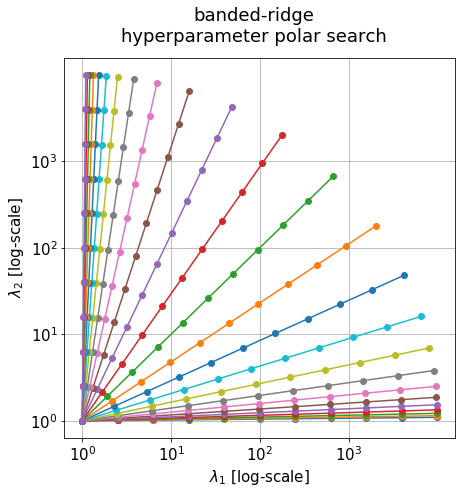

In [17]:
# Sampling in terms of ratios and scalings
alphas = np.logspace(0,4,11)
ratios = np.logspace(-2,2,25)

fig = plt.figure()
ax = fig.add_subplot(1,1,1)

for ratio in ratios:
    angle = np.arctan(ratio)
    ypos = np.sin(angle)*np.log10(alphas)
    xpos = np.cos(angle)*np.log10(alphas)
    ax.plot(xpos, ypos, 'o-')

ax.set_xticks([0, 1, 2, 3], minor=False)
ax.set_yticks([0, 1, 2, 3], minor=False)
__ = ax.set_xticklabels(['$10^0$', '$10^1$', '$10^2$', '$10^3$'], fontsize=15)
__ = ax.set_yticklabels(['$10^0$', '$10^1$', '$10^2$', '$10^3$'], fontsize=15)

# Labels
ax.set_xlabel(r'$\lambda_1$ [log-scale]')
ax.set_ylabel(r'$\lambda_2$ [log-scale]')
__ = fig.suptitle('banded-ridge\nhyperparameter polar search')
ax.grid(True)

The function `tikreg.estimate_stem_wmvnp()` implments polar sampling. In order to use this functionality, a couple of things must be specified. 


#### Define the priors

First, one feature spaces must serve as the reference feature space. To achieve this, the feature prior for this feature space must only contain one hyperparameter to test. 

`>>> X1_prior = spatial_priors.SphericalPrior(X1, hyparams=[1.0])`

This means that the other feature space will contain the ratios that we wish to test:

`>>> X2_prior = spatial_priors.SphericalPrior(X2, hyparams=ratios)`

#### Force hyperparameter normalization 

Second, the keyword argument `normalize_hyparams=True` must be set. This forces `tikreg` to normalize the hyperparametersthe such that they lie on the unit circle. This is achieved by dividing the hyperparameters by their norm. Because $\lambda_1$ is always 1:

$$[\lambda^{\text{norm}}_1,\lambda^{\text{norm}}_2] = \frac{[1.0, \lambda_2]}{||[1.0, \lambda_2]||_2}  $$

In [18]:
# The first feature space is the reference for the ratio (l2/l1) and so l1 is fixed as 1.
X1_prior = spatial_priors.SphericalPrior(X1, hyparams=[1.0]) 

# The second feature space contains the ratios to try
# These will be normalized internally in order to sample from the unit circle
X2_prior = spatial_priors.SphericalPrior(X2, hyparams=ratios)

temporal_prior = temporal_priors.SphericalPrior(delays=[0]) # no delays

fit_banded_polar = models.estimate_stem_wmvnp([X1, X2], Ytrain,
                                              [X1tst, X2tst],Ytest,
                                              feature_priors=[X1_prior, X2_prior],
                                              temporal_prior=temporal_prior,
                                              ridges=alphas,           # Solution for all alphas
                                              normalize_hyparams=True, # Normalizes the ratios
                                              folds=(1,5),
                                              performance=True,
                                              weights=True,
                                              verbosity=False)

Next, we compute the model weights for each voxel separately. To achieve this, we first find the optimal set of hyperparameters ($\lambda_1$, $\lambda_2$, $\alpha$) for each voxel

In [19]:
voxelwise_optimal_hyperparameters = fit_banded_polar['optima']
print(voxelwise_optimal_hyperparameters.shape)

(100, 4)


We then iterate through each voxel and compute its weights in the primal space.

In [20]:
kernel_weights = fit_banded_polar['weights']
primal_weights = []
for voxid, (temporal_lambda, lambda_one, lambda_two, alpha) in enumerate(voxelwise_optimal_hyperparameters):
    ws = np.dot(np.hstack([X1/lambda_one**2, X2/lambda_two**2]).T, kernel_weights[:,voxid]*alpha)
    primal_weights.append(ws)
primal_weights = np.asarray(primal_weights).T
print(primal_weights.shape)

(300, 100)


Because the model is linear, we can compute the individual voxel solutions much faster using matrix multiplication.

To achieve this, we get the optimal hyperparameter parameters for each voxel $i$ into vectors:

$$
\begin{align*}
\vec{\alpha} &= [\alpha_1, \alpha_2, \ldots,\alpha_i, \ldots \alpha_v]\\
\vec{\lambda_1} &= [\lambda_{1,1}, \lambda_{1,2}, \ldots,\lambda_{1,i}, \ldots \lambda_{1,v}]\\
\vec{\lambda_2} &= [\lambda_{2,1}, \lambda_{2,2}, \ldots,\lambda_{1,i}, \ldots \lambda_{2,v}]
\end{align*}
$$

where the subscript $i$ in $\alpha_i$, $\lambda_{1,i}$ and $\lambda_{2,i}$ corresponds to the voxel index. 

Each hyperparameter vectors therefore contains $v$ entries, one for each of the responses (e.g. voxels, neurons, etc).

In [21]:
alphas = voxelwise_optimal_hyperparameters[:,-1]
lambda_ones = voxelwise_optimal_hyperparameters[:,1]
lambda_twos = voxelwise_optimal_hyperparameters[:,2]


Then, we can simply use matrix multiplication to convert the estimated kernel weights 
$\hat{\omega} \in \mathbb{R}^{n \times v}$ into primal weights ($\hat{\beta}_{banded\_ridge} \in \mathbb{R}^{(p + q) \times v}$) for each feature space separately for each voxel:

$$
\hat{\beta}_1 = X_1^\top \hat{\omega} 
\left[\begin{array}{ccc}
\alpha_1 & \ldots & 0 \\
\vdots & \ddots & \vdots \\
0 & \ldots & \alpha_v \\
\end{array}\right]
\left[\begin{array}{ccc}
\left(\lambda_{1,1}\right)^{-2} & \ldots & 0 \\
\vdots & \ddots & \vdots \\
0 & \ldots & \left(\lambda_{1,v}\right)^{-2} \\
\end{array}\right]
$$

where $\hat{\beta}_1 \in \mathbb{R}^{p \times v}$ is the matrix containing all the $p$ weights for feature space $X_1$ for all $v$ voxels.

$$
\hat{\beta}_2 = X_2^\top \hat{\omega} 
\left[\begin{array}{ccc}
\alpha_1 & \ldots & 0 \\
\vdots & \ddots & \vdots \\
0 & \ldots & \alpha_v \\
\end{array}\right]
\left[\begin{array}{ccc}
\left(\lambda_{2,1}\right)^{-2} & \ldots & 0 \\
\vdots & \ddots & \vdots \\
0 & \ldots & \left(\lambda_{2,v}\right)^{-2} \\
\end{array}\right]
$$

where $\hat{\beta}_2 \in \mathbb{R}^{q \times v}$ is the matrix containing all the $q$ weights for feature space $X_2$ for all $v$ voxels.

To obtain the banded ridge weight estimate, we simply concatenate both weight matrices:

$$\hat{\beta}_{banded\_ridge} = 
\begin{bmatrix}
\hat{\beta}_1\\
\hat{\beta}_2
\end{bmatrix}
$$

In [22]:
kernel_weights = fit_banded_polar['weights']
weights_x1 = np.linalg.multi_dot([X1.T, kernel_weights, np.diag(alphas), np.diag(lambda_ones**-2)])
weights_x2 = np.linalg.multi_dot([X2.T, kernel_weights, np.diag(alphas), np.diag(lambda_twos**-2)])
weights_joint = np.vstack([weights_x1, weights_x2])
print(weights_joint.shape)
assert np.allclose(weights_joint, primal_weights)

(300, 100)
